Tao BoW tu copus va stop words

In [316]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

def build_bow_numpy(corpus, stop_words=None):
    stop_words = stop_words or set()

    tokenized = [
        [w.lower() for w in s.split() if w.lower() not in stop_words]
        for s in corpus
    ]

    vocab = sorted({w for sent in tokenized for w in sent})
    vocab_index = {w: i for i, w in enumerate(vocab)}

    bow_matrix = np.zeros((len(corpus), len(vocab)), dtype=np.int32)

    for i, sent in enumerate(tokenized):
        for word, cnt in Counter(sent).items():
            bow_matrix[i, vocab_index[word]] = cnt

    return vocab, vocab_index, bow_matrix


In [317]:
def vectorize_input(text, vocab_index, stop_words=None):
    stop_words = stop_words or set()
    vec = np.zeros(len(vocab_index), dtype=np.int32)

    for word in text.split():
        w = word.lower()
        if w not in stop_words and w in vocab_index:
            vec[vocab_index[w]] += 1

    return vec

In [318]:
def cosine_similarity(matrix, vector):
    dot = matrix @ vector
    norm_matrix = np.linalg.norm(matrix, axis=1)
    norm_vector = np.linalg.norm(vector)

    return dot / (norm_matrix * norm_vector + 1e-9)

In [319]:
def euclidean_distance(matrix, vector):
    return np.linalg.norm(matrix - vector, axis=1)

In [320]:
def retrieve_top_N(corpus,stop_words, test_doc, N=2, method='cosine', return_indices=False):
   vocab,vocab_index, bow_matrix = build_bow_numpy(corpus, stop_words)
   test_vector = vectorize_input(test_doc, vocab_index, stop_words)

   if method == 'cosine':
       score = cosine_similarity(bow_matrix, test_vector)
       top_idx = np.argsort(score)[::-1][:N]

   elif method == 'euclidean':
       score = euclidean_distance(test_vector, bow_matrix)
       top_idx = np.argsort(score)[:N]

   else:
       raise ValueError('Invalid method')

   if return_indices:
       return [(i, score[i]) for i in top_idx]
   return [(corpus[i], score[i]) for i in top_idx]

In [321]:
corpus = [
    "Tôi thích học Toán và Đại số tuyến tính",
    "Machine learning sử dụng nhiều toán học",
    "AI và machine learning là xu hướng công nghệ",
    "Deep learning dựa trên mạng nơ ron nhân tạo",
    "Toán và xác suất thống kê rất quan trọng trong AI",
    "Lập trình Python được dùng nhiều trong khoa học dữ liệu",
    "Khoa học dữ liệu kết hợp toán học và lập trình",
    "Âm nhạc giúp thư giãn sau giờ học căng thẳng",
    "Tôi thích nghe nhạc khi học bài",
    "Học AI cần kiến thức về toán và lập trình",
    "Xử lý ngôn ngữ tự nhiên là một nhánh của AI",
    "Computer vision giúp máy tính hiểu hình ảnh",
    "Mô hình học máy cần nhiều dữ liệu để huấn luyện",
    "Học sâu yêu cầu tài nguyên tính toán lớn",
    "Thống kê giúp phân tích dữ liệu hiệu quả"
]

stop_words = {
    "tôi", "và", "là", "của", "khi", "để", "trong", "một", "rất"
}

test_doc = "Tôi học AI và toán để làm khoa học dữ liệu"
N = 5

print("Method: Cosine Similarity")
results = retrieve_top_N(corpus, stop_words, test_doc, N=N, method='cosine')
for doc, score in results:
    print(f"Document: {doc}, Score: {score}")

print("\nMethod: Euclidean Distance")
results = retrieve_top_N(corpus, stop_words, test_doc, N=N, method='euclidean')
for doc, score in results:
    print(f"Document: {doc}, Score: {score}")

Method: Cosine Similarity
Document: Khoa học dữ liệu kết hợp toán học và lập trình, Score: 0.769800358845427
Document: Lập trình Python được dùng nhiều trong khoa học dữ liệu, Score: 0.5270462766391744
Document: Học AI cần kiến thức về toán và lập trình, Score: 0.4444444443950617
Document: Mô hình học máy cần nhiều dữ liệu để huấn luyện, Score: 0.42163702131133945
Document: Machine learning sử dụng nhiều toán học, Score: 0.3779644729616082

Method: Euclidean Distance
Document: Khoa học dữ liệu kết hợp toán học và lập trình, Score: 2.23606797749979
Document: Lập trình Python được dùng nhiều trong khoa học dữ liệu, Score: 3.0
Document: Tôi thích học Toán và Đại số tuyến tính, Score: 3.1622776601683795
Document: Machine learning sử dụng nhiều toán học, Score: 3.1622776601683795
Document: Tôi thích nghe nhạc khi học bài, Score: 3.1622776601683795


In [322]:
def load_cisi_documents(path):
    corpus = []
    with open(path, encoding="utf-8", errors="ignore") as f:
        text = ""
        reading = False
        for line in f:
            line = line.strip()
            if line.startswith(".I"):
                if text:
                    corpus.append(text)
                text = ""
                reading = False
            elif line.startswith(".W"):
                reading = True
            elif reading:
                text += " " + line
        if text:
            corpus.append(text)
    return corpus


In [323]:
def load_cisi_queries(path):
    queries = []
    with open(path, encoding="utf-8", errors="ignore") as f:
        text = ""
        reading = False
        for line in f:
            line = line.strip()
            if line.startswith(".I"):
                if text:
                    queries.append(text)
                text = ""
                reading = False
            elif line.startswith(".W"):
                reading = True
            elif reading:
                text += " " + line
        if text:
            queries.append(text)
    return queries


In [324]:
def load_stopwords(path):
    with open(path) as f:
        return set(w.strip().lower() for w in f)


In [325]:
def load_cisi_relevance(path):
    relevance = {}

    with open(path, encoding="utf-8", errors="ignore") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 2:
                continue

            qid = int(parts[0])
            doc_id = int(parts[1])

            # Trong CISI dataset, tất cả các cặp (query, doc) trong file này đều là relevant
            if qid not in relevance:
                relevance[qid] = set()
            relevance[qid].add(doc_id)

    return relevance


In [326]:
# Load dataset
corpus = load_cisi_documents("/Users/anhnon/Documents/HOCKY2/DATASCIENCE/BUOI_26_01/cisi-a-dataset-for-information-retrieval/CISI.ALL")
queries = load_cisi_queries("/Users/anhnon/Documents/HOCKY2/DATASCIENCE/BUOI_26_01/cisi-a-dataset-for-information-retrieval/CISI.QRY")
stop_words = load_stopwords("/Users/anhnon/Documents/HOCKY2/DATASCIENCE/BUOI_26_01/cisi-a-dataset-for-information-retrieval/stopwords.txt")
relevance = load_cisi_relevance("/Users/anhnon/Documents/HOCKY2/DATASCIENCE/BUOI_26_01/cisi-a-dataset-for-information-retrieval/CISI.REL")


print("Total documents:", len(corpus))
print("Test query:", test_doc[:2000])


Total documents: 1460
Test query: Tôi học AI và toán để làm khoa học dữ liệu


In [327]:
# Evaluation metrics
def precision_at_k(retrieved, relevant, k):
    """Calculate Precision@K"""
    retrieved_k = retrieved[:k]
    if len(retrieved_k) == 0:
        return 0.0
    return len(set(retrieved_k) & relevant) / len(retrieved_k)

def recall_at_k(retrieved, relevant, k):
    """Calculate Recall@K"""
    if len(relevant) == 0:
        return 0.0
    retrieved_k = retrieved[:k]
    return len(set(retrieved_k) & relevant) / len(relevant)

def average_precision(retrieved, relevant):
    """Calculate Average Precision for one query"""
    if len(relevant) == 0:
        return 0.0

    score = 0.0
    num_hits = 0.0

    for i, doc_id in enumerate(retrieved):
        if doc_id in relevant:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    return score / len(relevant) if len(relevant) > 0 else 0.0

def mean_average_precision(all_retrieved, relevance_dict):
    """Calculate MAP across all queries"""
    aps = []
    for qid, retrieved in all_retrieved.items():
        relevant = relevance_dict.get(qid, set())
        ap = average_precision(retrieved, relevant)
        aps.append(ap)
    return np.mean(aps) if aps else 0.0


In [328]:
# Evaluate retrieval system
def evaluate_retrieval(corpus, queries, stop_words, relevance, N=10, method='cosine'):
    """Evaluate retrieval system using CISI dataset"""

    # Build BoW once for efficiency
    vocab, vocab_index, bow_matrix = build_bow_numpy(corpus, stop_words)

    all_retrieved = {}
    precisions = []
    recalls = []

    for qid, query in enumerate(queries, start=1):
        # Vectorize query
        test_vector = vectorize_input(query, vocab_index, stop_words)

        # Calculate similarities
        if method == 'cosine':
            scores = cosine_similarity(bow_matrix, test_vector)
            top_idx = np.argsort(scores)[::-1][:N]
        elif method == 'euclidean':
            scores = euclidean_distance(bow_matrix, test_vector)
            top_idx = np.argsort(scores)[:N]
        else:
            raise ValueError('Invalid method')

        # Retrieved document IDs (1-indexed to match CISI.REL)
        retrieved_docs = [idx + 1 for idx in top_idx]
        all_retrieved[qid] = retrieved_docs

        # Get relevant documents for this query
        relevant = relevance.get(qid, set())

        # Calculate metrics
        if len(relevant) > 0:
            prec = precision_at_k(retrieved_docs, relevant, N)
            rec = recall_at_k(retrieved_docs, relevant, N)
            precisions.append(prec)
            recalls.append(rec)

    # Calculate overall metrics
    map_score = mean_average_precision(all_retrieved, relevance)
    avg_precision = np.mean(precisions) if precisions else 0.0
    avg_recall = np.mean(recalls) if recalls else 0.0

    return {
        'MAP': map_score,
        'Avg_Precision@K': avg_precision,
        'Avg_Recall@K': avg_recall,
        'all_retrieved': all_retrieved
    }


In [329]:
# Run evaluation
print("="*60)
print("EVALUATION ON CISI DATASET")
print("="*60)
print(f"Total documents: {len(corpus)}")
print(f"Total queries: {len(queries)}")
print(f"Queries with relevance judgments: {len(relevance)}")
print("="*60)

N = 10

print("\n*** Method: Cosine Similarity ***")
results_cosine = evaluate_retrieval(corpus, queries, stop_words, relevance, N=N, method='cosine')
print(f"MAP (Mean Average Precision): {results_cosine['MAP']:.4f}")
print(f"Precision@{N}: {results_cosine['Avg_Precision@K']:.4f}")
print(f"Recall@{N}: {results_cosine['Avg_Recall@K']:.4f}")

print("\n*** Method: Euclidean Distance ***")
results_euclidean = evaluate_retrieval(corpus, queries, stop_words, relevance, N=N, method='euclidean')
print(f"MAP (Mean Average Precision): {results_euclidean['MAP']:.4f}")
print(f"Precision@{N}: {results_euclidean['Avg_Precision@K']:.4f}")
print(f"Recall@{N}: {results_euclidean['Avg_Recall@K']:.4f}")


EVALUATION ON CISI DATASET
Total documents: 1460
Total queries: 112
Queries with relevance judgments: 76

*** Method: Cosine Similarity ***
MAP (Mean Average Precision): 0.0142
Precision@10: 0.0947
Recall@10: 0.0456

*** Method: Euclidean Distance ***
MAP (Mean Average Precision): 0.0010
Precision@10: 0.0184
Recall@10: 0.0044


In [330]:
# Show example results for first query
query_id = 1
print(f"\nExample: Query #{query_id}")
print(f"Query text: {queries[query_id-1][:2000]}")
print(f"\nRelevant documents (from CISI.REL): {sorted(relevance.get(query_id, set()))}")

print(f"\nTop {N} retrieved documents (Cosine Similarity):")
retrieved_docs = results_cosine['all_retrieved'][query_id]
relevant_set = relevance.get(query_id, set())
for rank, doc_id in enumerate(retrieved_docs, start=1):
    is_relevant = "✓ RELEVANT" if doc_id in relevant_set else "✗"
    print(f"  {rank}. Doc #{doc_id} {is_relevant}")
    print(f"     {corpus[doc_id-1][:1500]}")



Example: Query #1
Query text:  What problems and concerns are there in making up descriptive titles? What difficulties are involved in automatically retrieving articles from approximate titles? What is the usual relevance of the content of articles to their titles?

Relevant documents (from CISI.REL): [28, 35, 38, 42, 43, 52, 65, 76, 86, 150, 189, 192, 193, 195, 215, 269, 291, 320, 429, 465, 466, 482, 483, 510, 524, 541, 576, 582, 589, 603, 650, 680, 711, 722, 726, 783, 813, 820, 868, 869, 894, 1162, 1164, 1195, 1196, 1281]

Top 10 retrieved documents (Cosine Similarity):
  1. Doc #17 ✗
      There has long been a need for a continuing series to provide scholarly reviews of the rapidly changing and advancing field of librarianship, a series which would select subjects with particular current significance to the profession and provide an analysis of the advances made through research and practice.  Advances in Librarianship is planned and designed to fill this need.  It will present cr

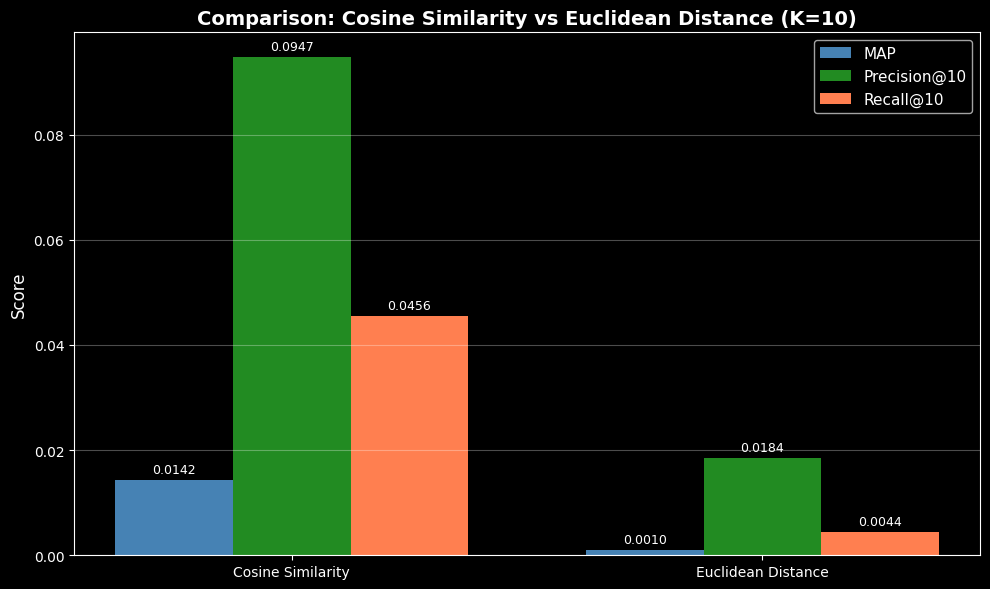

In [331]:
# Compare Cosine vs Euclidean
methods = ['Cosine Similarity', 'Euclidean Distance']
N = 10

cosine_res = evaluate_retrieval(corpus, queries, stop_words, relevance, N=N, method='cosine')
euclidean_res = evaluate_retrieval(corpus, queries, stop_words, relevance, N=N, method='euclidean')

map_scores = [cosine_res['MAP'], euclidean_res['MAP']]
precision_scores = [cosine_res['Avg_Precision@K'], euclidean_res['Avg_Precision@K']]
recall_scores = [cosine_res['Avg_Recall@K'], euclidean_res['Avg_Recall@K']]

x = np.arange(len(methods))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, map_scores, width, label='MAP', color='steelblue')
bars2 = ax.bar(x, precision_scores, width, label='Precision@10', color='forestgreen')
bars3 = ax.bar(x + width, recall_scores, width, label='Recall@10', color='coral')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Comparison: Cosine Similarity vs Euclidean Distance (K=10)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

plt.tight_layout()
plt.show()


SO SÁNH TỈ LẸ HIT (HIT RATE) GIỮA COSINE VÀ EUCLIDEAN
K          Cosine Hit Rate      Euclidean Hit Rate   Difference     
----------------------------------------------------------------------
1          0.1579               0.0263               +0.1316        
3          0.3158               0.0395               +0.2763        
5          0.3947               0.0658               +0.3289        
10         0.4737               0.1447               +0.3289        
20         0.6316               0.1974               +0.4342        
50         0.7895               0.4868               +0.3026        


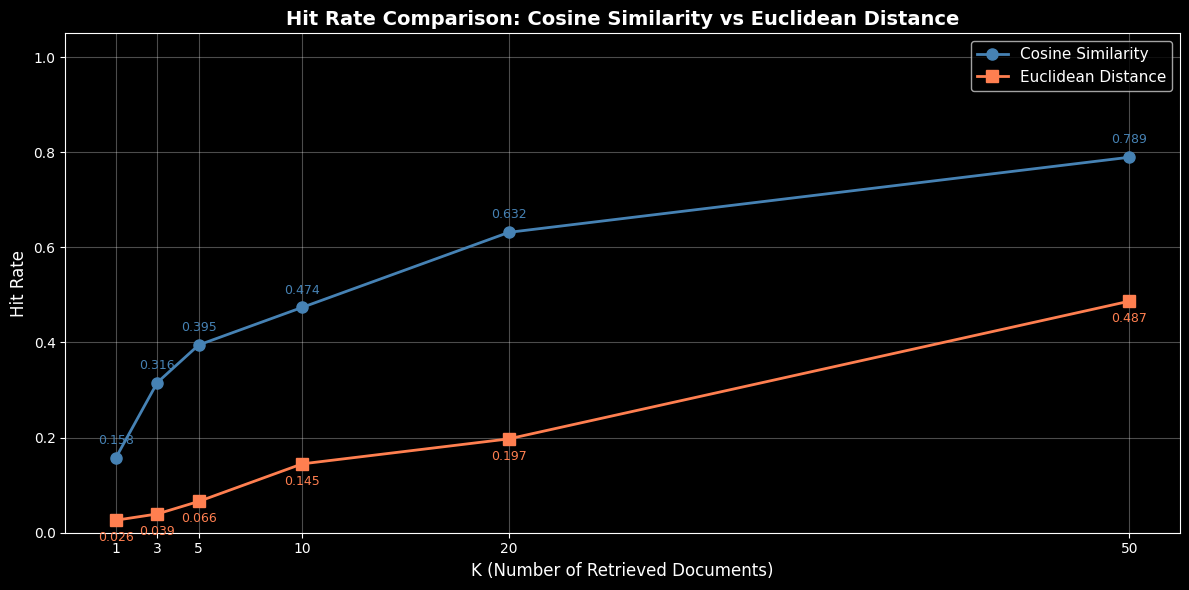


PHÂN TÍCH CHI TIẾT TỈ LỆ HIT TẠI K=10
Tổng số queries được đánh giá: 76

Cosine có hit:     36/76 (47.37%)
Euclidean có hit:  11/76 (14.47%)

Cả 2 đều hit:      9/76 (11.84%)
Chỉ Cosine hit:    27/76 (35.53%)
Chỉ Euclidean hit: 2/76 (2.63%)
Không có hit:      38/76 (50.00%)


In [332]:
# So sánh tỉ lệ hit (hit rate) giữa Cosine và Euclidean
import matplotlib.pyplot as plt

def calculate_hit_rate(all_retrieved, relevance_dict):
    """Tính tỉ lệ hit - số queries có ít nhất 1 relevant document trong top-K"""
    hits = 0
    total = 0

    for qid, retrieved in all_retrieved.items():
        relevant = relevance_dict.get(qid, set())
        if len(relevant) > 0:  # Chỉ tính các queries có relevance judgments
            total += 1
            # Kiểm tra xem có ít nhất 1 doc relevant trong kết quả trả về không
            if len(set(retrieved) & relevant) > 0:
                hits += 1

    return hits / total if total > 0 else 0.0

# Tính hit rate cho cả 2 phương pháp với các giá trị K khác nhau
K_values = [1, 3, 5, 10, 20, 50]
cosine_hit_rates = []
euclidean_hit_rates = []

print("="*70)
print("SO SÁNH TỈ LẸ HIT (HIT RATE) GIỮA COSINE VÀ EUCLIDEAN")
print("="*70)
print(f"{'K':<10} {'Cosine Hit Rate':<20} {'Euclidean Hit Rate':<20} {'Difference':<15}")
print("-"*70)

for k in K_values:
    # Evaluate với Cosine
    cosine_eval = evaluate_retrieval(corpus, queries, stop_words, relevance, N=k, method='cosine')
    cosine_hr = calculate_hit_rate(cosine_eval['all_retrieved'], relevance)
    cosine_hit_rates.append(cosine_hr)

    # Evaluate với Euclidean
    euclidean_eval = evaluate_retrieval(corpus, queries, stop_words, relevance, N=k, method='euclidean')
    euclidean_hr = calculate_hit_rate(euclidean_eval['all_retrieved'], relevance)
    euclidean_hit_rates.append(euclidean_hr)

    diff = cosine_hr - euclidean_hr
    print(f"{k:<10} {cosine_hr:<20.4f} {euclidean_hr:<20.4f} {diff:<+15.4f}")

print("="*70)

# Vẽ biểu đồ so sánh hit rate
plt.figure(figsize=(12, 6))
plt.plot(K_values, cosine_hit_rates, marker='o', linewidth=2, markersize=8,
         label='Cosine Similarity', color='steelblue')
plt.plot(K_values, euclidean_hit_rates, marker='s', linewidth=2, markersize=8,
         label='Euclidean Distance', color='coral')

plt.xlabel('K (Number of Retrieved Documents)', fontsize=12)
plt.ylabel('Hit Rate', fontsize=12)
plt.title('Hit Rate Comparison: Cosine Similarity vs Euclidean Distance', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(K_values)
plt.ylim([0, 1.05])

# Thêm annotations cho các điểm
for i, k in enumerate(K_values):
    plt.annotate(f'{cosine_hit_rates[i]:.3f}',
                xy=(k, cosine_hit_rates[i]),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                fontsize=9,
                color='steelblue')
    plt.annotate(f'{euclidean_hit_rates[i]:.3f}',
                xy=(k, euclidean_hit_rates[i]),
                xytext=(0, -15),
                textcoords='offset points',
                ha='center',
                fontsize=9,
                color='coral')

plt.tight_layout()
plt.show()

# Phân tích chi tiết cho K=10
print("\n" + "="*70)
print("PHÂN TÍCH CHI TIẾT TỈ LỆ HIT TẠI K=10")
print("="*70)

K = 10
cosine_eval_10 = evaluate_retrieval(corpus, queries, stop_words, relevance, N=K, method='cosine')
euclidean_eval_10 = evaluate_retrieval(corpus, queries, stop_words, relevance, N=K, method='euclidean')

cosine_hits = 0
euclidean_hits = 0
both_hit = 0
only_cosine = 0
only_euclidean = 0
none_hit = 0
total_queries = 0

for qid in cosine_eval_10['all_retrieved'].keys():
    relevant = relevance.get(qid, set())
    if len(relevant) == 0:
        continue

    total_queries += 1

    cosine_retrieved = set(cosine_eval_10['all_retrieved'][qid])
    euclidean_retrieved = set(euclidean_eval_10['all_retrieved'][qid])

    cosine_has_hit = len(cosine_retrieved & relevant) > 0
    euclidean_has_hit = len(euclidean_retrieved & relevant) > 0

    if cosine_has_hit:
        cosine_hits += 1
    if euclidean_has_hit:
        euclidean_hits += 1

    if cosine_has_hit and euclidean_has_hit:
        both_hit += 1
    elif cosine_has_hit:
        only_cosine += 1
    elif euclidean_has_hit:
        only_euclidean += 1
    else:
        none_hit += 1

print(f"Tổng số queries được đánh giá: {total_queries}")
print(f"\nCosine có hit:     {cosine_hits}/{total_queries} ({cosine_hits/total_queries*100:.2f}%)")
print(f"Euclidean có hit:  {euclidean_hits}/{total_queries} ({euclidean_hits/total_queries*100:.2f}%)")
print(f"\nCả 2 đều hit:      {both_hit}/{total_queries} ({both_hit/total_queries*100:.2f}%)")
print(f"Chỉ Cosine hit:    {only_cosine}/{total_queries} ({only_cosine/total_queries*100:.2f}%)")
print(f"Chỉ Euclidean hit: {only_euclidean}/{total_queries} ({only_euclidean/total_queries*100:.2f}%)")
print(f"Không có hit:      {none_hit}/{total_queries} ({none_hit/total_queries*100:.2f}%)")
print("="*70)


